

# ***Wonkota Newsletters***
Jimmy Feterman
Alex Vainer (mentor)

# **The Problem**

Email newsletters have become an essential medium for information dissemination, covering topics as diverse as politics, business, cooking, and self-care. Because of their popularity, the volume of newsletters is overwhelming for readers who struggle to find relevant updates amid redundant or unrelated content.


According to data from StoryDoc 74% of readers subscribed to newsletters are subscribed to more than one newsletter (and up to even 10 different newsletters). Subscribing to multiple newsletters makes it challenging to keep track of important updates and often leads to redundant content from overlapping sources.



We developed a system utilizing large language models (LLMs) and natural language processing (NLP) techniques to extract, classify, and synthesize newsletter content into a concise, personalized format. The system collects high-quality newsletters, identifies relevant content based on user preferences, and synthesizes it into a cohesive, customized newsletter. This approach minimizes redundancy and maximizes relevance, streamlining the reader experience.


# **The Data**


---


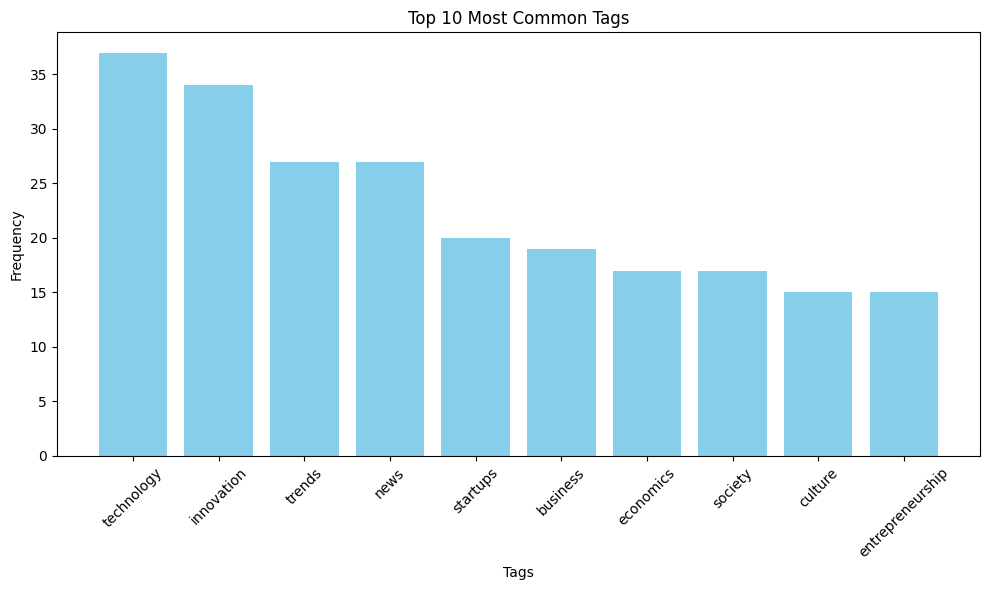

* Number of newsletters: 70

* Number of unique tags: 159

* Average number of tags per newsletter: 10.0

# **Our Approach:**

**Prompt-chaining**:https://dl.acm.org/doi/pdf/10.1145/3491102.3517582

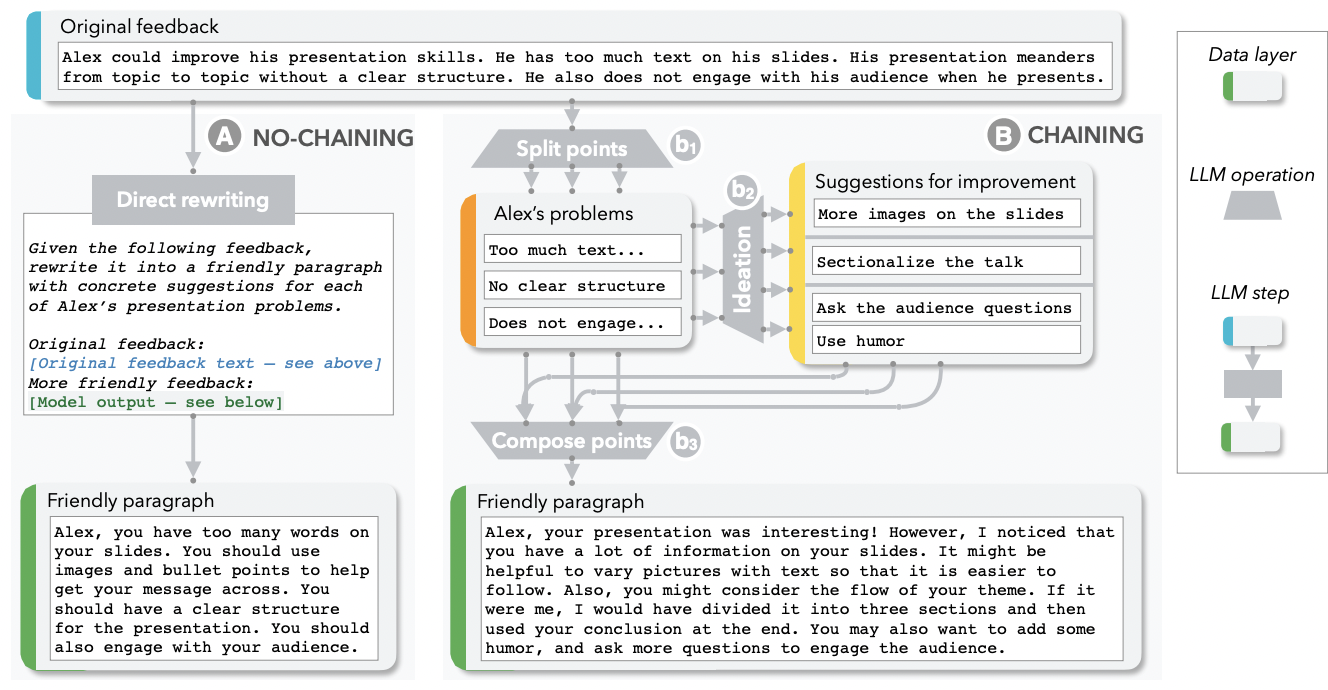

**Story spine**

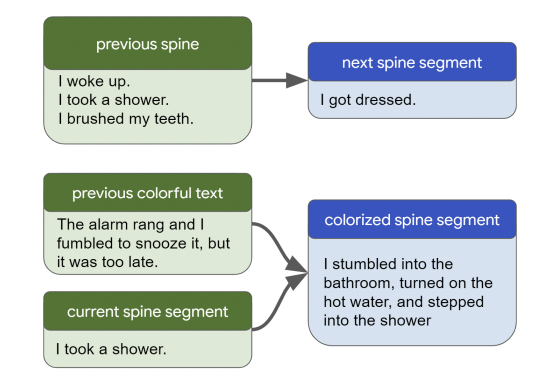



*   In test #1, the prompt chain outperformed the single prompt with an average score of 3.68/5 to 3.52/5.
* In test #2,  the prompt chain outperformed the single prompt with an average score of 4.68/5 to 4.56/5
  * Contrary to our hypothesis, increasing the dataset didn’t have a major impact on the single prompt, and we didn’t even observe a large discrepancy in test #2 between single prompt and prompt chain.


# **Demo**

In [ ]:
!pip uninstall openai
!pip cache purge
!pip install openai --force-reinstall

Found existing installation: openai 1.57.0
Uninstalling openai-1.57.0:
  Would remove:
    /usr/local/bin/openai
    /usr/local/lib/python3.10/dist-packages/openai-1.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/openai/*
Proceed (Y/n)? y
  Successfully uninstalled openai-1.57.0
Files removed: 96
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.0/457.0 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2

In [ ]:
import pandas as pd
import openai
from time import sleep

newsletter_df = pd.read_csv("/content/drive/MyDrive/Capstone/fresh_newsletters.csv")

In [ ]:
#import openai
from openai import Client  # Try this instead of OpenAI

client = Client(api_key="XXXXXXXXXXXXX")

In [ ]:
#RUN IN LOCAL ENVIRONEMNT IN VS CODE. WILL NOT WORK IN COLAB

#Gmail API code
import os
import pickle
import google.auth
import base64
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from datetime import datetime, timedelta, timezone
import pandas as pd
import re

# Define the scope for Gmail API
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

# Function to authenticate Gmail API
def authenticate_gmail():
    creds = None
    token_path = 'token.pickle'

    # Check if token.pickle file exists
    if os.path.exists(token_path):
        with open(token_path, 'rb') as token:
            creds = pickle.load(token)

    # If no valid credentials are available, let the user log in
    if not creds or not creds.valid:
        try:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                raise google.auth.exceptions.RefreshError
        except google.auth.exceptions.RefreshError:
            print("Token has expired or been revoked. Re-authenticating...")
            if os.path.exists(token_path):
                os.remove(token_path)  # Delete the invalid token file
            flow = InstalledAppFlow.from_client_secrets_file(
                '/Users/jimmyfeterman/GmailAPI/client_secret_wonkota.json', SCOPES
            )
            creds = flow.run_local_server(port=8080)

        # Save the credentials for future use
        with open(token_path, 'wb') as token:
            pickle.dump(creds, token)

    return creds


# Function to build the Gmail service
def get_gmail_service():
    creds = authenticate_gmail()
    service = build('gmail', 'v1', credentials=creds)
    return service

# Function to extract the newsletter name from the sender's email address
def get_newsletter_name(email_address):
    match = re.search(r'(\w+)@', email_address)
    if match:
        return match.group(1)
    else:
        return None

# Function to list the messages in the inbox sent in the last 24 hours and put them in a DataFrame
def get_messages_to_dataframe(service):
    # Calculate the timestamp for 24 hours ago
    yesterday = datetime.now(timezone.utc) - timedelta(days=1)
    query = f'newer_than:1d'

    results = service.users().messages().list(userId='me', q=query).execute()
    messages = results.get('messages', [])

    if not messages:
        print("No messages found.")
        return pd.DataFrame()
    else:
        print(f"Found {len(messages)} messages sent in the last 24 hours.")

        data = []
        for message in messages:
            msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
            body = get_message_body(msg)
            headers = msg['payload']['headers']
            from_header = next((header['value'] for header in headers if header['name'] == 'From'), None)

            # Extract just the newsletter name (before the < character)
            if from_header:
                newsletter_name = from_header.split('<')[0].strip()  # Get the name before the email
            else:
                newsletter_name = "Unknown"

            data.append({'newsletter_name': newsletter_name, 'content': body})

        return pd.DataFrame(data)

# Function to extract and decode the message body
def get_message_body(msg):
    if 'parts' in msg['payload']:
        for part in msg['payload']['parts']:
            if part['mimeType'] == 'text/plain':
                body = part['body']['data']
                return base64.urlsafe_b64decode(body).decode('utf-8')
            elif part['mimeType'] == 'text/html':
                body = part['body']['data']
                return base64.urlsafe_b64decode(body).decode('utf-8')
    elif msg['payload']['mimeType'] in ['text/plain', 'text/html']:
        body = msg['payload']['body']['data']
        return base64.urlsafe_b64decode(body).decode('utf-8')

    return "No plain text or HTML part found."

if __name__ == "__main__":
    # Get the Gmail service
    service = get_gmail_service()
    # Get the messages and put them in a DataFrame
    messages_df = get_messages_to_dataframe(service)
    print(messages_df)
    # Save the DataFrame to a CSV file
    messages_df.to_csv('fresh_newsletters.csv', index=False)

In [ ]:
#run_gpt4 function to use the client
def run_gpt4(prompt, return_first_line=False, instruction_tuned=True):

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            max_tokens=600,
            top_p=1,
            frequency_penalty=0.2,
            presence_penalty=0.0
        )
        response = completion.choices[0].message.content.strip()
        return response
    except Exception as e:
        print(f"Error in API call: {str(e)}")
        return ""

In [ ]:
# Define the newsletter names and their corresponding tags, with all entries included

tags_dict = {
    "Newsletter": [
        "MorningBrew", "RetailBrew", "HealthcareBrew", "Benedict’s Newsletter",
        "Stratechery", "The Hustle", "CB Insights", "a16z enterprise",
        "a16z American Dynamism", "a16z Consumer", "Not Boring",
        "Paul Graham’s Essays", "a16z Bio+Health", "a16z Fintech",
        "ProductHunt", "The Daily Upside", "Margins", "AxiosMediaTrends",
        "Axios Communicators", "Axios AI+", "Axios Crypto", "Axios Miami",
        "Axios Vitals", "Axios Latino", "Axios Future of Defense",
        "Axios Generate", "Axios Finish Line", "Axios Essential",
        "Finimize", "NextDraft", "TheBrowser", "DenseDiscovery", "TLDR AI",
        "Recomendo", "theSkimm", "Brain Food", "Azeem Azhar, Exponential View",
        "Contrarian Crew", "Sahil Bloom's Newsletter", "Mark Manson's Your Next Breakthrough",
        "Of Dollars and Data", "Data Elixir", "3-2-1 Thursday newsletter (James Clear)",
        "The Variable", "Boing Boing", "TheLeap", "Simon Rosenberg - Hopium Chronicles",
        "The Athletic", "Bleacher Report", "The New York Times",
        "Serious Eats", "America's Test Kitchen", "AP News Alerts",
        "AP Sports Wire", "NPR Newsletter", "The New York Times",
        "WSJ News Debrief", "WSJ Sports",
        "LA Times Policy Newsletter", "The New York Times",
        "The New York Times", "Matthew Berry", "Bleacher Report AM",
        "TLDR Web Dev", "The Athletic Pulse", "TLDR Product", "TLDR InfoSec","Ben Pershing, WSJ", "DAILYGOOD", "Karma Kitchen"
    ],
    "Tags": [
        ["business", "finance", "technology", "productivity", "economics", "innovation", "news", "investing", "career", "leadership"],
        ["business", "retail", "e-commerce", "marketing", "consumer behavior", "branding", "advertising", "supply chain", "trends", "entrepreneurship"],
        ["healthcare", "medicine", "biotechnology", "innovation", "public health", "mental health", "health tech", "fitness", "wellness", "nutrition"],
        ["technology", "innovation", "startups", "economics", "venture capital", "entrepreneurship", "leadership", "trends", "strategy", "business"],
        ["technology", "business", "innovation", "startups", "strategy", "economics", "investing", "productivity", "leadership", "entrepreneurship"],
        ["business", "startups", "entrepreneurship", "innovation", "marketing", "finance", "leadership", "technology", "trends", "strategy"],
        ["business", "technology", "investing", "data", "venture capital", "startups", "innovation", "finance", "market trends", "enterprise"],
        ["enterprise", "technology", "business", "startups", "innovation", "cloud computing", "big data", "machine learning", "AI", "enterprise software"],
        ["innovation", "technology", "startups", "policy", "entrepreneurship", "venture capital", "defense", "public policy", "governance", "national security"],
        ["consumer", "technology", "startups", "entrepreneurship", "innovation", "trends", "retail", "marketing", "e-commerce", "venture capital"],
        ["business", "technology", "startups", "innovation", "investing", "venture capital", "productivity", "economics", "strategy", "entrepreneurship"],
        ["entrepreneurship", "startups", "economics", "technology", "innovation", "writing", "strategy", "business", "philosophy", "leadership"],
        ["biotechnology", "healthcare", "medicine", "innovation", "startups", "public health", "biotech", "genetics", "wellness", "nutrition"],
        ["finance", "technology", "fintech", "innovation", "startups", "blockchain", "cryptocurrency", "investing", "venture capital", "economics"],
        ["technology", "startups", "innovation", "productivity", "apps", "software", "trends", "entrepreneurship", "design", "development"],
        ["business", "finance", "investing", "economics", "news", "market trends", "strategy", "technology", "leadership", "entrepreneurship"],
        ["business", "technology", "economics", "investing", "startups", "trends", "finance", "market trends", "strategy", "enterprise"],
        ["media", "technology", "advertising", "news", "trends", "digital marketing", "branding", "consumer behavior", "entertainment", "social media"],
        ["media", "communication", "branding", "advertising", "public relations", "marketing", "social media", "news", "content creation", "digital marketing"],
        ["AI", "technology", "machine learning", "data", "innovation", "startups", "robotics", "automation", "future of work", "trends"],
        ["cryptocurrency", "blockchain", "technology", "finance", "investing", "innovation", "fintech", "trends", "economics", "markets"],
        ["local news", "technology", "business", "innovation", "startups", "real estate", "development", "entrepreneurship", "trends", "governance"],
        ["healthcare", "medicine", "public health", "mental health", "fitness", "biotechnology", "wellness", "innovation", "nutrition", "trends"],
        ["culture", "politics", "diversity", "latin america", "news", "social justice", "education", "community", "governance", "international affairs"],
        ["technology", "defense", "national security", "innovation", "startups", "policy", "AI", "robotics", "military", "public policy"],
        ["energy", "technology", "innovation", "sustainability", "climate change", "renewable energy", "environment", "trends", "policy", "governance"],
        ["business", "productivity", "sports", "leadership", "motivation", "mental health", "personal growth", "news", "lifestyle", "strategy"],
        ["business", "news", "finance", "economics", "technology", "innovation", "market trends", "strategy", "leadership", "entrepreneurship"],
        ["finance", "investing", "economics", "business", "technology", "market trends", "startups", "entrepreneurship", "innovation", "personal finance"],
        ["technology", "news", "culture", "media", "politics", "literature", "trends", "society", "philosophy", "internet"],
        ["technology", "design", "creativity", "media", "innovation", "ux/ui", "productivity", "trends", "news", "development"],
        ["technology", "startups", "innovation", "news", "trends", "apps", "productivity", "development", "software", "enterprise"],
        ["productivity", "life hacks", "tools", "innovation", "personal growth", "motivation", "recommendations", "wellness", "lifestyle", "self-improvement"],
        ["news", "politics", "culture", "technology", "trends", "society", "internet", "media", "entertainment", "literature"],
        ["design", "creativity", "innovation", "tools", "productivity", "digital marketing", "trends", "technology", "media", "development"],
        ["technology", "AI", "machine learning", "data", "automation", "robotics", "trends", "future of work", "innovation", "apps"],
        ["productivity", "recommendations", "life hacks", "tools", "self-improvement", "wellness", "personal growth", "motivation", "lifestyle", "creativity"],
        ["news", "lifestyle", "entertainment", "culture", "current events", "personal growth", "career", "productivity", "women", "society"],
        ["self-improvement", "learning", "creativity", "inspiration", "personal growth", "motivation", "wellness", "career", "mindfulness", "philosophy"],
        ["technology", "innovation", "economics", "business", "science", "politics", "environment", "society", "future trends", "globalization"],
        ["entrepreneurship", "startups", "innovation", "business", "technology", "leadership", "personal growth", "venture capital", "economics", "career"],
        ["personal growth", "motivation", "self-improvement", "creativity", "philosophy", "psychology", "wellness", "mental health", "productivity", "relationships"],
        ["investing", "finance", "economics", "personal finance", "data", "money management", "retirement", "wealth", "market trends", "strategy"],
        ["data", "technology", "analytics", "machine learning", "AI", "trends", "tools", "visualization", "business intelligence", "development"],
        ["self-improvement", "motivation", "personal growth", "philosophy", "productivity", "recommendations", "mindfulness", "wellness", "habits", "creativity"],
        ["science", "technology", "innovation", "research", "trends", "news", "future", "society", "knowledge", "learning"],
        ["technology", "news", "culture", "internet", "trends", "innovation", "society", "entertainment", "media", "pop culture"],
        ["politics", "news", "society", "current events", "culture", "international affairs", "governance", "policy", "education", "world affairs"],
        ["sports", "entertainment", "news", "current events", "culture", "community", "social media", "society", "trends", "internet"],
        ["food", "cooking", "recipes", "kitchen tips", "nutrition", "wellness", "healthy eating", "dining", "culture", "lifestyle"],
        ["food", "cooking", "recipes", "kitchen tips", "nutrition", "dining", "wellness", "ingredients", "healthy eating", "culinary"],
        ["cooking", "recipes", "food science", "kitchen tips", "nutrition", "wellness", "healthy eating", "techniques", "culinary", "dining"],
        ["news", "alerts", "current events", "breaking news", "politics", "international", "society", "media", "science", "world affairs"],
        ["sports", "news", "alerts", "current events", "media", "entertainment", "society", "politics", "culture", "trends"],
        ["news", "culture", "politics", "current events", "media", "society", "trends", "international", "community", "education"],
        ["food", "cooking", "recipes", "kitchen tips", "nutrition", "wellness", "healthy eating", "dining", "culture", "lifestyle"],
        ["business", "finance", "economics", "market trends", "news", "strategy", "technology", "investing", "enterprise", "innovation"],
        ["sports", "news", "entertainment", "current events", "culture", "community", "trends", "society", "media", "politics"],
        ["politics", "news", "current events", "government", "society", "education", "international affairs", "policy", "analysis", "economics"],
        ["politics", "policy", "current events", "government", "news", "society", "analysis", "education", "law", "international"],
        ["news", "current events", "politics", "society", "international", "alerts", "breaking news", "analysis", "media", "culture"],
        ["sports", "fantasy sports", "entertainment", "NFL", "football", "community", "news", "analysis", "lifestyle", "trends"],
        ["sports", "entertainment", "news", "culture", "analysis", "NFL", "community", "society", "current events", "lifestyle"],
        ["technology", "development", "web dev", "programming", "software", "tools", "apps", "internet", "coding", "innovation"],
        ["sports", "news", "analysis", "culture", "community", "current events", "entertainment", "lifestyle", "society", "media"],
        ["technology", "startups", "product", "innovation", "apps", "entrepreneurship", "development", "software", "tools", "strategy"],
        ["security", "infosec", "technology", "cybersecurity", "privacy", "hacking", "tools", "trends", "software", "internet"],
        ["politics", "U.S. news", "policy", "government", "economics", "market trends", "international affairs", "media", "business", "finance"],
        ["mindfulness", "personal growth", "philosophy", "inspiration", "wellness", "self-care", "creativity", "motivation", "reflection", "spirituality"],
        ["community", "philanthropy", "generosity", "gift economy", "sustainability", "altruism", "social impact", "kindness", "food culture", "collaboration"]



    ]
}

In [ ]:
#SANITY CHECK

#Check the length of each list in tags_dict
newsletter_list = tags_dict["Newsletter"]
tags_list = tags_dict["Tags"]

#Check and print if there is a length mismatch
if len(newsletter_list) != len(tags_list):
    print(f"Mismatch detected! 'Newsletter' has {len(newsletter_list)} entries, while 'Tags' has {len(tags_list)} entries.")

    # Print each entry with its index to find the mismatched ones
    print("\nNewsletter entries:")
    for i, newsletter in enumerate(newsletter_list, start=1):
        print(f"{i}: {newsletter}")

    print("\nTags entries:")
    for i, tags in enumerate(tags_list, start=1):
        print(f"{i}: {tags}")
else:
    print("Both lists have the same length and should be compatible for DataFrame creation.")

#If no mismatch is found, proceed with creating the DataFrame
if len(newsletter_list) == len(tags_list):
    import pandas as pd
    tags_df = pd.DataFrame(tags_dict)
    print(tags_df)


Both lists have the same length and should be compatible for DataFrame creation.
               Newsletter                                               Tags
0             MorningBrew  [business, finance, technology, productivity, ...
1              RetailBrew  [business, retail, e-commerce, marketing, cons...
2          HealthcareBrew  [healthcare, medicine, biotechnology, innovati...
3   Benedict’s Newsletter  [technology, innovation, startups, economics, ...
4             Stratechery  [technology, business, innovation, startups, s...
..                    ...                                                ...
65           TLDR Product  [technology, startups, product, innovation, ap...
66           TLDR InfoSec  [security, infosec, technology, cybersecurity,...
67      Ben Pershing, WSJ  [politics, U.S. news, policy, government, econ...
68              DAILYGOOD  [mindfulness, personal growth, philosophy, ins...
69          Karma Kitchen  [community, philanthropy, generosity, gift ec

In [ ]:
#TAKE A PEAK AT THE NEWSLETTERS
newsletter_df['newsletter_name']

,newsletter_name
0,Healthcare Brew
1,Retail Brew
2,Axios Communicators
3,NYT Cooking
4,The Browser
5,"""Azeem Azhar, Exponential View"""
6,Simon Rosenberg - Hopium Chronicles
7,"""Axios AI+"""
8,The Wall Street Journal
9,TLDR AI


In [ ]:
#filter newsletters to only include those that match the specified interests
interests = ["sports", "politics", "technology"]

relevant_newsletters_list = []
for tag in interests:
  for index, row in tags_df.iterrows():
    if tag in row['Tags']:
      relevant_newsletters_list.append(row['Newsletter'])

relevant_newsletters_list

['Axios Finish Line',
 'Bleacher Report',
 'AP Sports Wire',
 'WSJ Sports',
 'Matthew Berry',
 'Bleacher Report AM',
 'The Athletic Pulse',
 'Axios Latino',
 'NextDraft',
 'Recomendo',
 "Mark Manson's Your Next Breakthrough",
 'The Athletic',
 'AP News Alerts',
 'AP Sports Wire',
 'NPR Newsletter',
 'WSJ Sports',
 'LA Times Policy Newsletter',
 'The New York Times',
 'The New York Times',
 'Ben Pershing, WSJ',
 'MorningBrew',
 'Benedict’s Newsletter',
 'Stratechery',
 'The Hustle',
 'CB Insights',
 'a16z enterprise',
 'a16z American Dynamism',
 'a16z Consumer',
 'Not Boring',
 'Paul Graham’s Essays',
 'a16z Fintech',
 'ProductHunt',
 'The Daily Upside',
 'Margins',
 'AxiosMediaTrends',
 'Axios AI+',
 'Axios Crypto',
 'Axios Miami',
 'Axios Future of Defense',
 'Axios Generate',
 'Axios Essential',
 'Finimize',
 'NextDraft',
 'TheBrowser',
 'DenseDiscovery',
 'Recomendo',
 'theSkimm',
 'Brain Food',
 "Mark Manson's Your Next Breakthrough",
 'Of Dollars and Data',
 'The Variable',
 'TheL

In [ ]:
#Take subsection of API data that matches relevant newsletters
filtered_data = newsletter_df[newsletter_df['newsletter_name'].isin(relevant_newsletters_list)]

In [ ]:
# Dictionary of interests to hold generated newsletter data
content_dict = {interest: [] for interest in interests}

# Prompt Chain

In [ ]:
#CHERRY PICK SUMMMARIZE CONTENT ACROSS ALL FILTERED NEWSLETTERS

# Convert filtered_data to CSV format as a string
filtered_data_text = filtered_data.to_csv(index=False)
# Divide data into chunks
chunk_size = 3
chunks = [filtered_data[i:i+chunk_size] for i in range(0, len(filtered_data), chunk_size)]

# Process each chunk
for interest in interests:
    synthesized_articles = []
    for chunk in chunks:
        chunk_text = chunk['content'].to_csv(index=False)
        prompt = f"""
{chunk_text} includes the copy of different newsletters.
Summarize all content that is related to {interest} in plain text, and ignore any content unrelated to {interest}.
Do NOT write introductory phrases, headers, or explanations.
Ignore any content unrelated to {interest}.
"""
        relevant_articles = run_gpt4(
            prompt,
            return_first_line=False,
            instruction_tuned=True
        )
        synthesized_articles.append(relevant_articles)

    # Combine results from all chunks
    content_dict[interest].append("\n".join(synthesized_articles))


In [ ]:
content_dict['sports']

["There is no content related to sports in the provided newsletters.\nHong Kong’s flagship airline, Cathay Pacific, issued a public apology after an episode of the cartoon Family Guy that referenced the Tiananmen Square protests was included in its inflight entertainment system.\n\nAs of Friday morning, Juan Soto has not signed anywhere, but reports suggest a contract beyond $700 million is a possibility, specifically $750 million over 15 years, which could mean $50 million every year until 2039.\n\nJeff Passan expects a signing by December 9. Toronto is making a strong push for Soto, while Boston wants to know a number. Mets owner Steve Cohen's deep pockets loom over everything.\n\nIn NFL news, Dan Campbell went for it in a recent game against the Packers. The Green Bay head coach explained a fan altercation incident. Jadeveon Clowney expressed his dislike for Eagles fans.\n\nIme Udoka was fined $50,000 by the NBA. Urban Meyer rumors are back regarding Ohio State. The Blackhawks fired

In [ ]:
#CLEAN UP TEXT
for interest, content in content_dict.items():
    prompt = f"""
        Remove URLS, emojis, and any references to the original newsletter authors from {content}
        """
    no_link = run_gpt4(
            prompt,
            return_first_line=False,
            instruction_tuned=True
        )
    content_dict[interest] = no_link

In [ ]:
content_dict['sports']

"There is no content related to sports in the provided newsletters.\n\nHong Kong’s flagship airline, Cathay Pacific, issued a public apology after an episode of a cartoon that referenced the Tiananmen Square protests was included in its inflight entertainment system.\n\nAs of Friday morning, Juan Soto has not signed anywhere, but reports suggest a contract beyond $700 million is a possibility, specifically $750 million over 15 years, which could mean $50 million every year until 2039.\n\nExpectations are for a signing by December 9. Toronto is making a strong push for Soto, while Boston wants to know a number. Mets owner Steve Cohen's deep pockets loom over everything.\n\nIn NFL news, a head coach went for it in a recent game against the Packers. The Green Bay head coach explained a fan altercation incident. A player expressed his dislike for Eagles fans.\n\nA coach was fined $50,000 by the NBA. Rumors are back regarding Ohio State. A team fired their head coach.\n\nChampionship games 

In [ ]:
#NEWSLETTER STYLE
for interest, content in content_dict.items():

    prompt = f"""


Synthesize {content} in the style of an email newsletter
Make sure each story is diverse and represents different subtopics
Include all of the information in {content} and exclude content unrelated to {interest}
Avoid any introductory sections, emojis, calls to action, or references to links.
"""
    newzy = run_gpt4(
            prompt,
          return_first_line=False,
            instruction_tuned=True
        )
    content_dict[interest] = newzy

In [ ]:
content_dict['sports']

"**Cathay Pacific Apology**  \nHong Kong’s flagship airline, Cathay Pacific, issued a public apology after an episode of a cartoon that referenced the Tiananmen Square protests was included in its inflight entertainment system.\n\n**Juan Soto Contract Talks**  \nAs of Friday morning, Juan Soto has not signed anywhere, but reports suggest a contract beyond $700 million is a possibility, specifically $750 million over 15 years, which could mean $50 million every year until 2039. Expectations are for a signing by December 9. Toronto is making a strong push for Soto, while Boston wants to know a number. Mets owner Steve Cohen's deep pockets loom over everything.\n\n**NFL Coaching Decisions**  \nIn NFL news, a head coach went for it in a recent game against the Packers. The Green Bay head coach explained a fan altercation incident. A player expressed his dislike for Eagles fans. Additionally, a coach was fined $50,000 by the NBA.\n\n**College Football Championship Games**  \nChampionship ga

In [ ]:
#swap models

def newsletterGPT(prompt, return_first_line=False, instruction_tuned=True):
    """
    Runs a GPT-4 model prompt and returns the synthesized output.

    Parameters:
        prompt (str): The input prompt for the model.
        return_first_line (bool): If True, only returns the first line of the response.
        instruction_tuned (bool): Flag to indicate whether the model is instruction-tuned.

    Returns:
        str: The model's response to the prompt.
    """
    # Additional cache logic could go here if necessary
    try:
        # Configuring the GPT-4 model with optimized parameters for robustness
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,  # Lowered temperature for more deterministic output
            max_tokens=1200,  # Increased max_tokens for longer and more detailed newsletters
            top_p=1.0,  # Ensuring diversity is still factored in
            frequency_penalty=0.2,  # Penalizes repeated phrases or content
            presence_penalty=0.1  # Encourages slight creativity in structuring but not too much
        )
        response = completion.choices[0].message.content.strip()

        if return_first_line:
            return response.split("\n", 1)[0]  # Return the first line only if requested

        return response
    except Exception as e:
        print(f"Error in API call: {str(e)}")
        return ""


In [ ]:
#Synthesize

combined_content = "\n\n".join(
    f"**{interest.capitalize()}**\n{''.join(articles)}"
    for interest, articles in content_dict.items()
)

prompt = f"""
The following are newsletters with specified categories:

{combined_content}

Synthesize the content and format it as an email newsletter in plain text.
Every category in {interests} must be represented with content.
Avoid including any introductory sections, emojis, calls to action, or references to links.
"""

final_newsletter = newsletterGPT(
        prompt,
        return_first_line=False,
        instruction_tuned=True
    )

In [ ]:
prompt = f"""
{final_newsletter} is the raw content of a newsletter with updates on {interests}. The text is disorganized and needs refinement. Your task is to clean up the content so that:

1. Each paragraph focuses on a single topic and is clear, concise, and easy to read.
2. Information flows logically within each section, with no abrupt topic changes.
3. Redundant or unnecessary details are removed while retaining all key information.
4. The overall tone is professional and cohesive, suitable for an email newsletter.
5. Any cross-references or overlapping content between sections are integrated smoothly.

Refine this content and format it as a polished email newsletter. Ensure the content in each section is cohesive and logically structured.
"""

cleaned_final_newsletter = newsletterGPT(
        prompt,
        return_first_line=False,
        instruction_tuned=True
    )

In [ ]:
cleaned_final_newsletter

"Subject: Weekly Update: Sports Highlights, Political Developments, and Tech News\n\nDear Readers,\n\nWelcome to this week’s newsletter, where we bring you the latest updates in sports, politics, and technology.\n\n**Sports Update**  \nCathay Pacific recently issued a public apology after a cartoon episode referencing the Tiananmen Square protests was included in its inflight entertainment. In Major League Baseball (MLB), Juan Soto remains unsigned, with reports indicating that he could command a contract exceeding $700 million, particularly from the Toronto Blue Jays. In the NFL, the Detroit Lions secured a thrilling victory over the Green Bay Packers with a score of 34-31 in Thursday Night Football. This win marks their 11th consecutive victory and clinches a playoff berth, positioning the Lions as Super Bowl favorites. Additionally, college football championship games are set to feature matchups between Georgia and Texas, as well as Penn State and Oregon.\n\n**Political Developments

END